In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [4]:
# load the frequency data

with open('balearic_frequency_cleaned.pkl', 'rb') as file:
    frequency_data_raw = pickle.load(file)

frequency_data_raw.index = frequency_data_raw.index.tz_localize('UTC')
frequency_data_raw.index = frequency_data_raw.index.tz_convert('Europe/Madrid')

frequency_data = frequency_data_raw.copy()

In [165]:
from scraper import SpanishScraper
import os

#load the generation data

if os.path.isfile("generation_data.pkl"):
    with open('generation_data.pkl', 'rb') as file:
        generation_data = pickle.load(file)
else:
    # select system and date range
    system = 'Baleares'
    startdate = '2019-09-29'
    enddate = '2023-07-01'

    # request data
    generation_data = SpanishScraper().get(system, startdate, enddate)
    generation_data.to_pickle("generation_data.pkl")  


# Event Analysis

In [166]:
from events import get_events

# get the events

positive_events = get_events(frequency_data=frequency_data, threshold=(frequency_data > 150), max_gap_length=5, event_end=0, event_start=0)

negative_events = get_events(frequency_data=frequency_data, threshold=(frequency_data < -150), max_gap_length=5, event_end=0, event_start=0)

In [88]:
len(positive_events), len(negative_events)

(969, 1390)

/var/folders/fr/kpnwttwn1g10yj13h5670vlw0000gn/T/ipykernel_39107/3305591018.py:9: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  positive_events['YearMonth'] = positive_events['Start'].dt.to_period('M').astype(str)
/var/folders/fr/kpnwttwn1g10yj13h5670vlw0000gn/T/ipykernel_39107/3305591018.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  negative_events['YearMonth'] = negative_events['Start'].dt.to_period('M').astype(str)


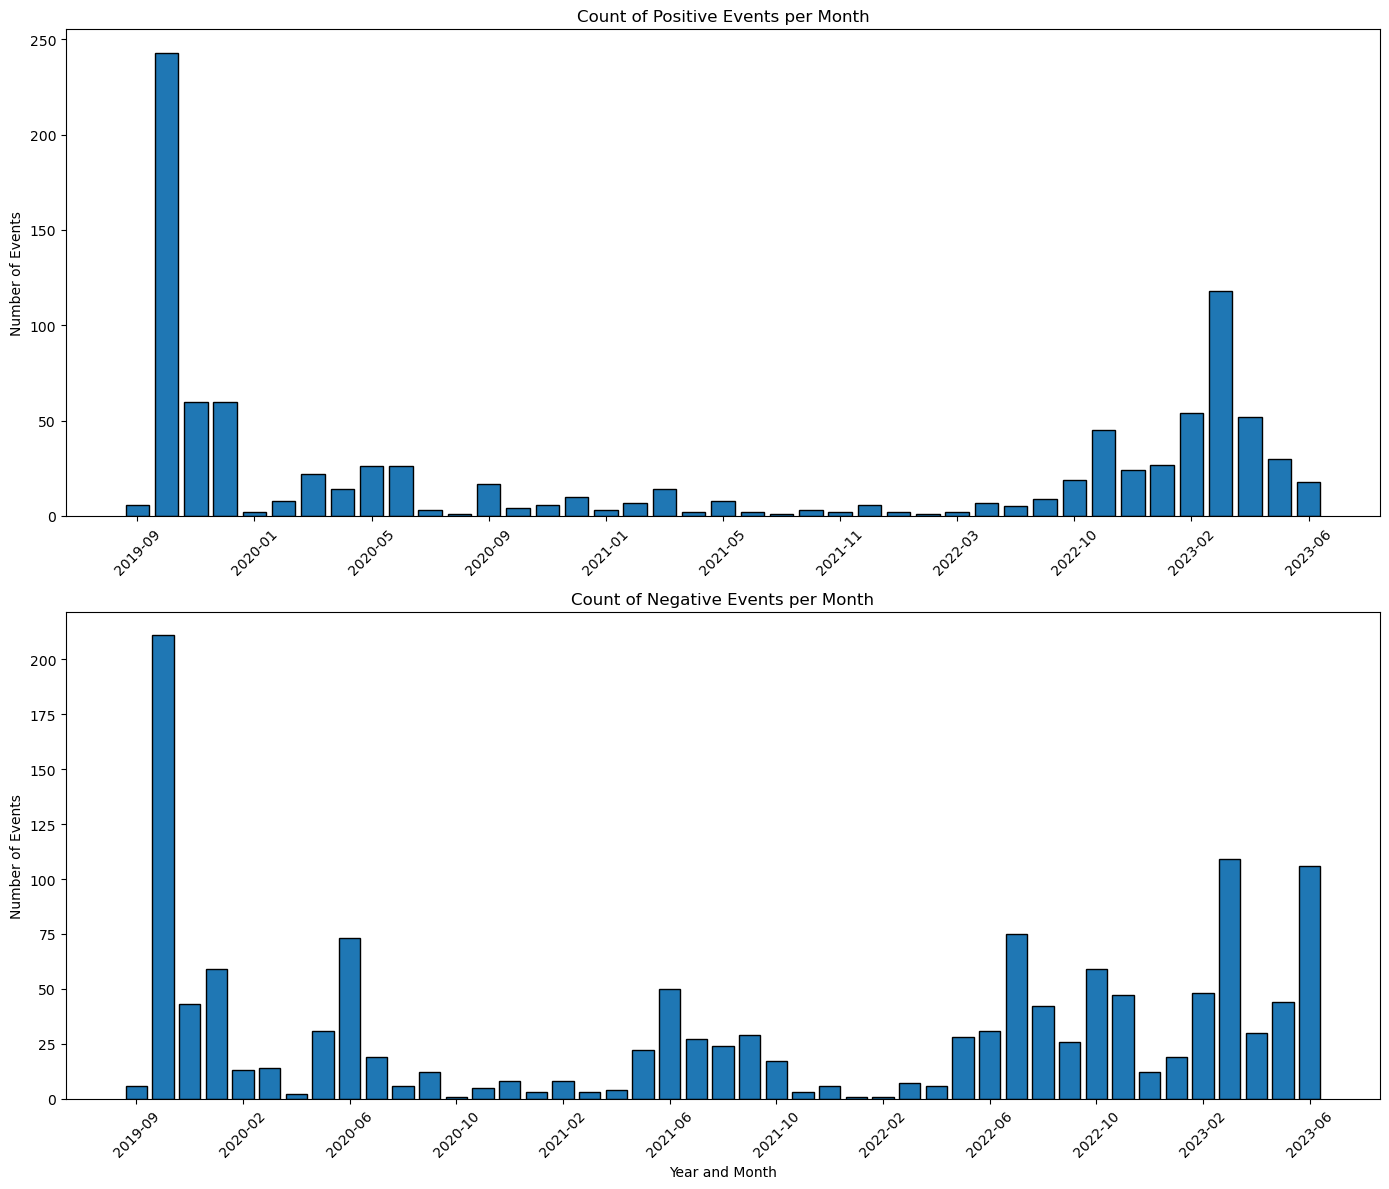

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# For positive events
positive_events['YearMonth'] = positive_events['Start'].dt.to_period('M').astype(str)
monthly_positive_counts = positive_events.groupby('YearMonth').size().reset_index(name='EventCount')

# For negative events
negative_events['YearMonth'] = negative_events['Start'].dt.to_period('M').astype(str)
monthly_negative_counts = negative_events.groupby('YearMonth').size().reset_index(name='EventCount')

# Function to filter x-ticks to show every fourth month
def filter_ticks(labels):
    # Determine which labels to show: Every fourth month starting from October
    filtered_labels = [label for i, label in enumerate(labels) if i % 4 == 0]
    return filtered_labels

# Plotting with filtered x-ticks
fig, axs = plt.subplots(2, 1, figsize=(14, 12))  # 2 rows, 1 column subplot

# Positive Events
axs[0].bar(monthly_positive_counts['YearMonth'], monthly_positive_counts['EventCount'], edgecolor='k')
axs[0].set_title('Count of Positive Events per Month')
axs[0].set_ylabel('Number of Events')
# Apply filtered x-ticks
filtered_labels_positive = filter_ticks(monthly_positive_counts['YearMonth'])
axs[0].set_xticks(filtered_labels_positive)
axs[0].set_xticklabels(filtered_labels_positive, rotation=45)

# Negative Events
axs[1].bar(monthly_negative_counts['YearMonth'], monthly_negative_counts['EventCount'], edgecolor='k')
axs[1].set_title('Count of Negative Events per Month')
axs[1].set_xlabel('Year and Month')
axs[1].set_ylabel('Number of Events')
# Apply filtered x-ticks
filtered_labels_negative = filter_ticks(monthly_negative_counts['YearMonth'])
axs[1].set_xticks(filtered_labels_negative)
axs[1].set_xticklabels(filtered_labels_negative, rotation=45)

plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.savefig(f'plots/event_amount.pdf')
plt.show()


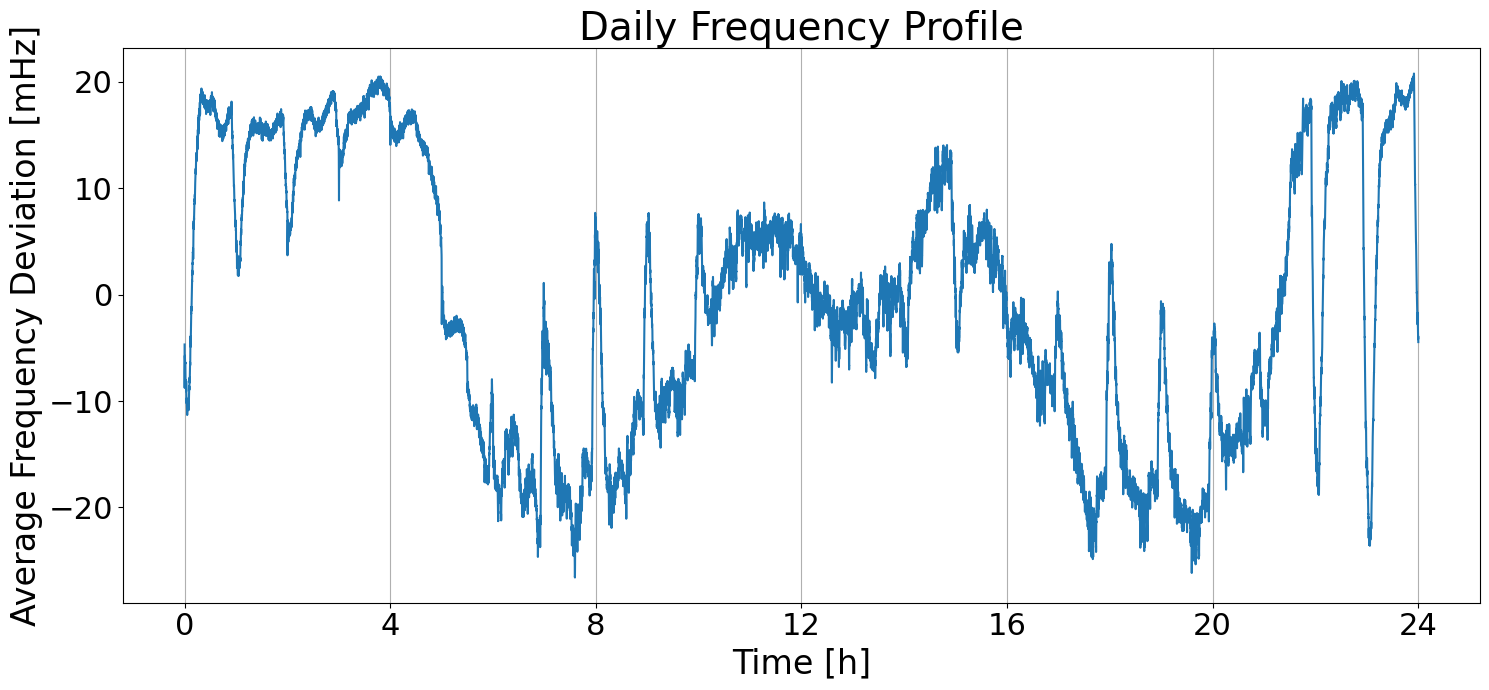

In [7]:
def plot_daily_profile(frequency_data, figsize=(15, 7), save_fig=False, save_text=False):
    """
    Plots a daily profile of frequency data.

    Parameters:
    - frequency_data: A pandas DataFrame with a DateTimeIndex and frequency data in columns.
    - figsize: Tuple specifying the figure size.
    - label_fontsize: Font size for the labels.
    - ticks_fontsize: Font size for the axis ticks.
    - save_fig: Boolean indicating whether to save the figure as a PDF.
    - save_text: Boolean indicating whether to save the profile data as text.
    - out_path: Output path for saving the figure and text data.
    - plot_title: Title for the plot.
    """
    
    # Calculate daily profile (average frequency for each minute of the day)
    frequency_data = frequency_data.copy()
    frequency_data = frequency_data.to_frame()
    frequency_data['time'] = frequency_data.index.time
    data_day_profile = frequency_data.groupby('time').mean()
    
    # Convert time objects to fractional hours (e.g., 00:30:00 -> 0.5)
    fractional_hours = [t.hour + t.minute / 60. + t.second / 3600. for t in data_day_profile.index]
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(fractional_hours, data_day_profile.values, label='Average Frequency')

  
    ax.set_xlabel('Time [h]', fontsize=24)
    ax.set_ylabel('Average Frequency Deviation [mHz]', fontsize=24)
    ax.set_title('Daily Frequency Profile', fontsize=28)
    ax.grid(True, which='both', axis='x')
    
    # Setting x-ticks to show every hour
    ax.set_xticks(np.arange(24))
    ax.set_xticks(np.arange(0, 25, 4), minor=False)
    ax.tick_params(axis='both', which='both', labelsize=22)
    
    plt.tight_layout()
    
    # Save plot and/or data if requested
    if save_fig:
        plt.savefig(f'plots/daily_profile.pdf')
    if save_text:
        np.savetxt(f'plots/frequency_profile.txt', data_day_profile.values)
    
    plt.show()
plot_daily_profile(frequency_data, save_fig=True)

/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


finished


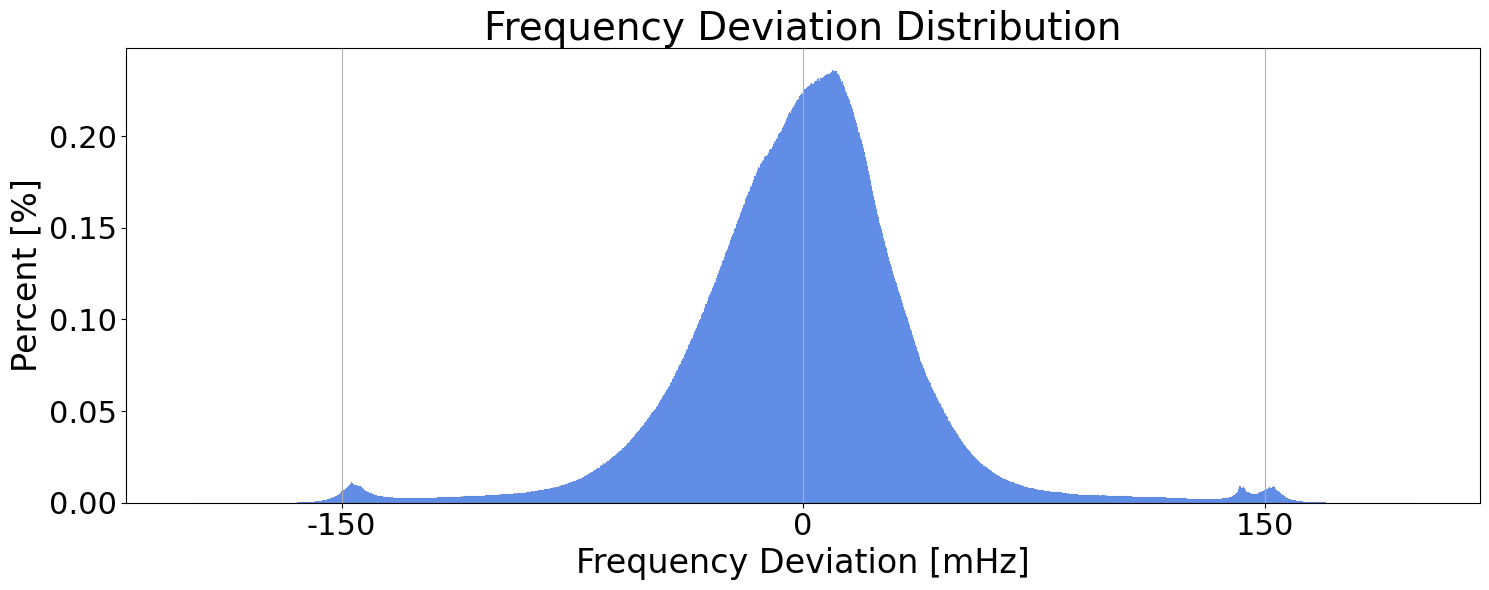

In [7]:



def frequency_histogram(frequency_data, figsize=(15, 6), label_fontsize=14, ticks_fontsize=12, save_fig=False, save_text=False, out_path='', plot_title='Frequency Distribution Histogram'):
    """
    Plots a histogram of frequency data with enhanced aesthetics and vertical gridlines only.

    Parameters:
    - frequency_data: A pandas Series or 1D-array-like object containing frequency measurements.
    - figsize: Figure size.
    - label_fontsize: Font size for labels.
    - ticks_fontsize: Font size for tick labels.
    - save_fig: Whether to save the figure.
    - save_text: Whether to save the data as text.
    - out_path: Output path for saving.
    - plot_title: Plot title.

    Returns:
    - A matplotlib Axes object of the histogram plot.
    """
    frequency_data = frequency_data.copy()

    plt.figure(figsize=figsize)
    ax = sns.histplot(frequency_data, stat="percent", binrange=(-200, 200), color="#3d7afd", legend=False)

    ax.set_xlabel('Frequency Deviation [mHz]', fontsize=24)
    ax.set_ylabel('Percent [%]', fontsize=24)
    ax.set_title('Frequency Deviation Distribution', fontsize=28)
    
    # Setting x-ticks to show every hour
    custom_ticks = [-150, 0, 150]
    ax.set_xticks(custom_ticks)
    ax.set_xticklabels([str(tick) for tick in custom_ticks])
    ax.tick_params(axis='both', which='both', labelsize=22)
    ax.grid(True, which='both', axis='x')
    plt.tight_layout()

    # If saving the figure, save in a high-quality format
    print("finished")
    if save_fig:
        plt.savefig(f'plots/frequency_distribution_histogram.pdf', format='pdf')

    if save_text:
        frequency_data.to_csv(f'{out_path}frequency_data.txt', index=False)

    plt.show()



frequency_histogram(frequency_data, save_fig=True)

In [5]:
# Assuming generation_data is your DataFrame and generation_types are your columns
generation_types = ['generation_coal', 'generation_diesel_engines', 'generation_gas_turbine', 
                    'generation_combined_cycle', 'generation_solar', 'generation_wind', 
                    'generation_other_renewables', 'generation_waste', 'generation_auxiliary', 
                    'generation_cogeneration', 'balearic_peninsula_link']

# Calculate the sum of generation for each technology
generation_totals = generation_data[generation_types].sum()

# Calculate the total generation across all technologies
total_generation = generation_totals.sum()

# Calculate the percentage of total generation for each technology
generation_percentages = (generation_totals / total_generation) * 100

# Convert the series to a DataFrame for nicer formatting and potential export
generation_percentages_df = generation_percentages.reset_index()
generation_percentages_df.columns = ['Generation Technology', 'Percentage of Total Generation (%)']

# Display the DataFrame
print(generation_percentages_df)

          Generation Technology  Percentage of Total Generation (%)
0               generation_coal                            4.273083
1     generation_diesel_engines                            6.299433
2        generation_gas_turbine                            5.657200
3     generation_combined_cycle                           55.861380
4              generation_solar                            3.527974
5               generation_wind                            0.048233
6   generation_other_renewables                            0.036117
7              generation_waste                            4.637559
8          generation_auxiliary                            0.157530
9       generation_cogeneration                            0.651302
10      balearic_peninsula_link                           18.850190


In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates


def event_plotter(events, frequency_data, generation_data, date):
    frequency_data_day = frequency_data.loc[date]
    generation_data_day = generation_data.loc[date]
    events = events.copy()

    date = pd.to_datetime(date).date()

    # Convert 'Start' to datetime if it's not already
    events['Start'] = pd.to_datetime(events['Start'])

    # Filter events where the start date is the same as 'date'
    events = events[events['Start'].dt.date == date]

    plt.figure(figsize=(15, 10))

    ax1 = plt.gca()  # Get the current axes instance
    ax1.plot(generation_data_day.index, generation_data_day['balearic_peninsula_link'], label='HVDC Link', color='C0')
    ax1.set_ylabel('HVDC Link Generation [MW]', fontsize=24)
    ax1.tick_params(axis='y', which='both', labelsize=22)
    ax1.set_ylim(0, 400)  # Set Generation value range from 0 to 300
    custom_ticks = [0, 100, 200,300, 400]
    ax1.set_yticks(custom_ticks)
    ax1.set_yticklabels([str(tick) for tick in custom_ticks])
    ax1.set_title(f'Event Showcase on {date}', fontsize=28)
    ax1.set_xlabel('Time [h]', fontsize=24)

    
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=4))  # Set major ticks to every 4 hours
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format the ticks to show hours
    ax1.set_xticklabels(np.arange(0, 25, 4), minor=False, fontsize=22)
    
    ax1.grid(which='both', axis='x', color='gray', alpha=0.2)

    ax2 = ax1.twinx()
    ax2.plot(frequency_data_day.index, frequency_data_day, label='Frequency', color='grey', alpha=0.5)
    ax2.set_ylabel('Frequency Deviation [mHz]', fontsize=24)
    ax2.tick_params(axis='y', which='both', labelsize=22)
    ax2.set_ylim(-200, 200)  # Set Frequency value range from -200 to 200
    custom_ticks = [-150, 0, 150]
    ax2.set_yticks(custom_ticks)
    ax2.set_yticklabels([str(tick) for tick in custom_ticks])


    for val in custom_ticks:
        ax2.axhline(y=val, color='grey', linestyle='-', alpha=0.2)
    # Plot each event with a distinct color
    colors = plt.cm.viridis(np.linspace(0, 1, len(events)))
    i = 0
    for (index, event_row), color in zip(events.iterrows(), colors):
        if pd.to_datetime(event_row['Start']).date() == pd.to_datetime(date).date():
            event_period = frequency_data_day[event_row['Start']:event_row['End']]
            ax2.plot(event_period.index, event_period, label=f'Event {i}', color=color)
            i += 1

    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)
    
    plt.savefig(f'plots/event_showcase.pdf', format='pdf')

    
    plt.tight_layout()
    plt.show()


/var/folders/fr/kpnwttwn1g10yj13h5670vlw0000gn/T/ipykernel_55914/917619758.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.arange(0, 25, 4), minor=False, fontsize=22)


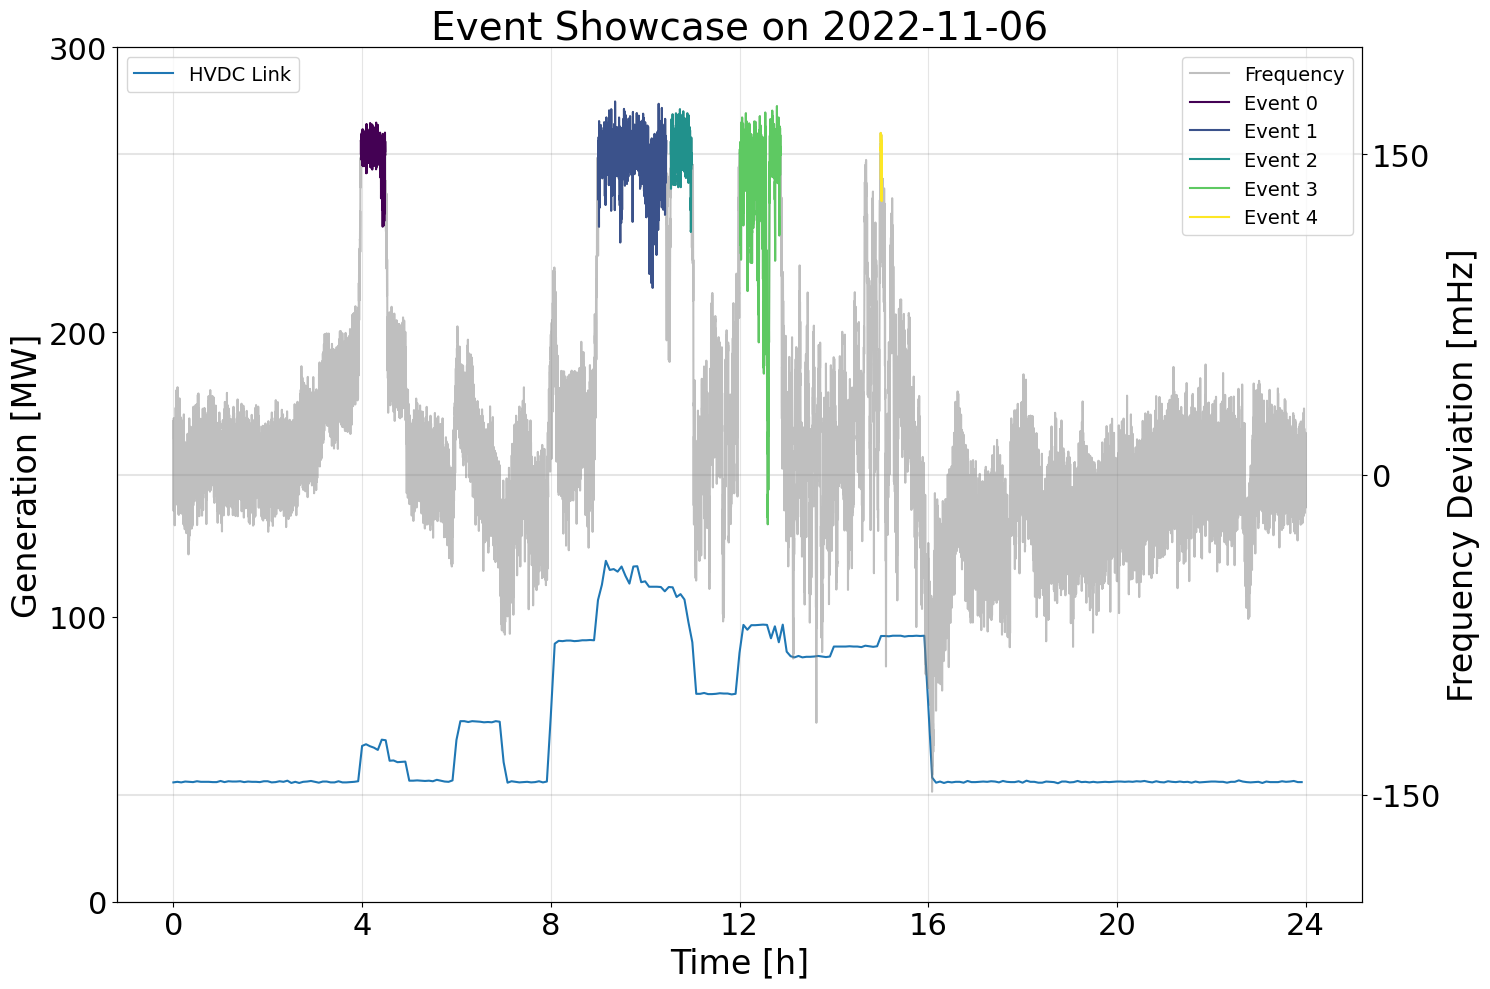

In [114]:

event_plotter(positive_events, frequency_data, generation_data, date='2022-11-06')

/var/folders/fr/kpnwttwn1g10yj13h5670vlw0000gn/T/ipykernel_39107/1251197692.py:12: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date = pd.to_datetime(date).date()
/var/folders/fr/kpnwttwn1g10yj13h5670vlw0000gn/T/ipykernel_39107/1251197692.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(np.arange(0, 25, 4), minor=False, fontsize=22)


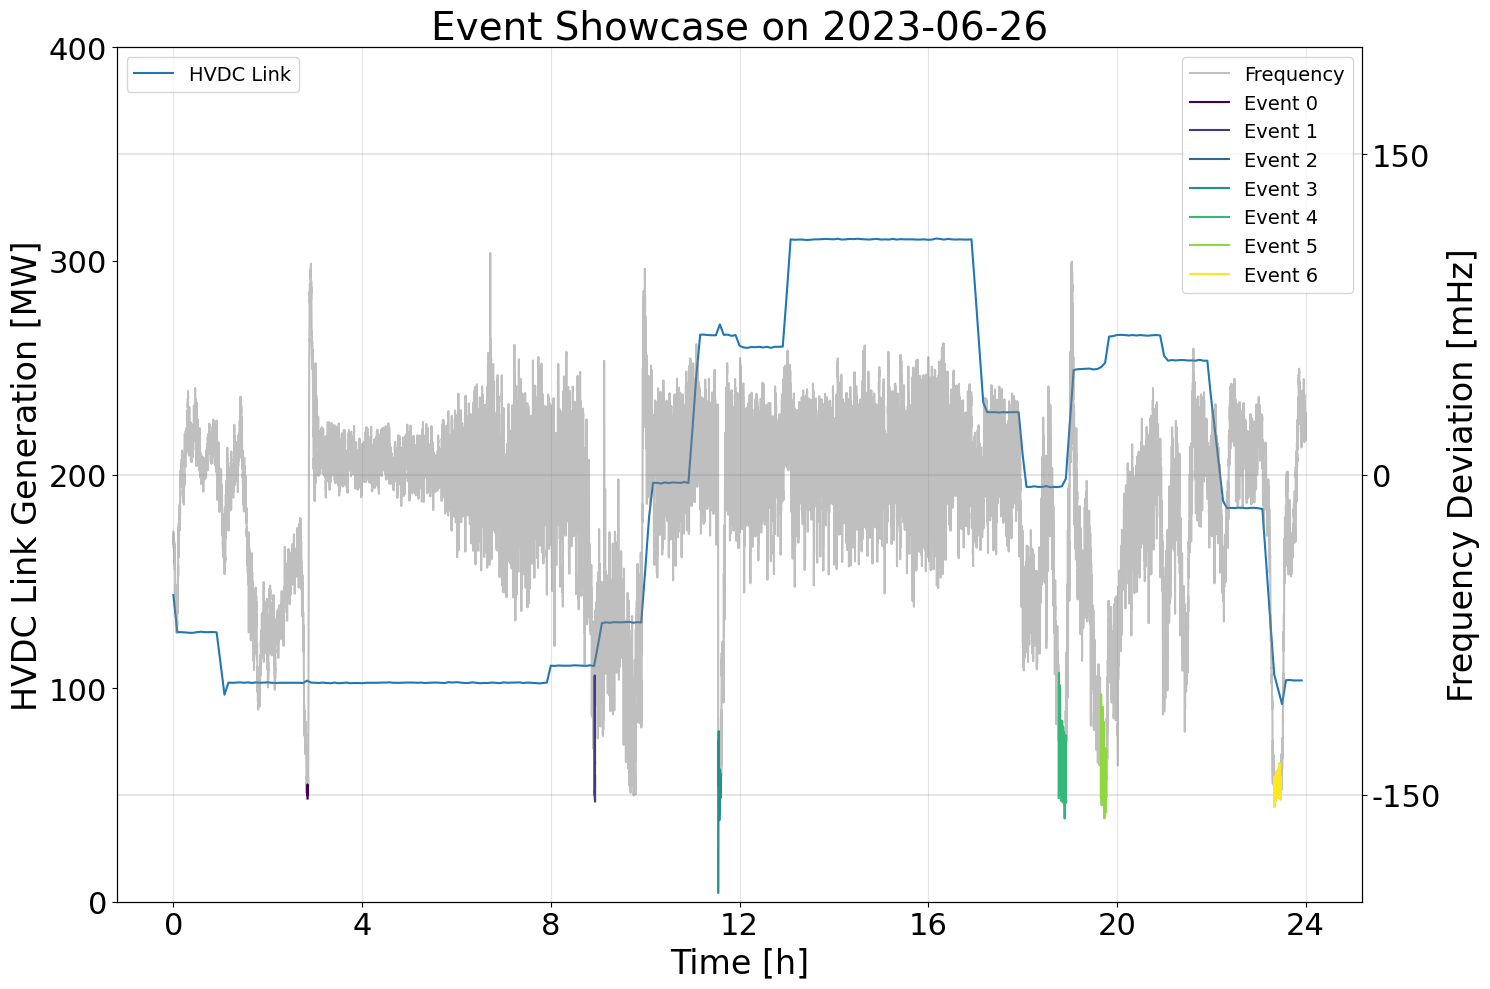

In [86]:

event_plotter(negative_events, frequency_data, generation_data, date='26-06-2023')

In [79]:
def single_event_plotter(events, frequency_data, generation_data, date):
    date = pd.to_datetime(date).date()
    
    frequency_data_day = frequency_data.loc[f'{date} 18:00':f'{date} 22:01']
    generation_data_day = generation_data.loc[f'{date} 18:00':f'{date} 22:01']

    # Convert 'Start' to datetime if it's not already
    events['Start'] = pd.to_datetime(events['Start'])

    # Filter events where the start date is the same as 'date'
    events = events[events['Start'].dt.date == date]

    plt.figure(figsize=(15, 10))

    ax1 = plt.gca()  # Get the current axes instance
    ax1.plot(generation_data_day.index, generation_data_day['balearic_peninsula_link'], label='HVDC Link', color='C0')
    ax1.set_ylabel('HVDC Link Generation [MW]', fontsize=24)
    ax1.tick_params(axis='y', which='both', labelsize=22)
    ax1.set_ylim(0, 300)  # Set Generation value range from 0 to 300
    custom_ticks = [0, 100, 200,300]
    ax1.set_yticks(custom_ticks)
    ax1.set_yticklabels([str(tick) for tick in custom_ticks])
    ax1.set_title(f'Event Showcase on {date}', fontsize=28)
    ax1.set_xlabel('Time [h]', fontsize=24)

    
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set major ticks to every 4 hours
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H'))  # Format the ticks to show hours


    
    
    ax1.grid(which='both', axis='x', color='gray', alpha=0.2)

    ax2 = ax1.twinx()
    ax2.plot(frequency_data_day.index, frequency_data_day, label='Frequency', color='grey', alpha=0.5)
    ax2.set_ylabel('Frequency Deviation [mHz]', fontsize=24)
    ax2.tick_params(axis='y', which='both', labelsize=22)
    ax2.set_ylim(-200, 200)  # Set Frequency value range from -200 to 200
    custom_ticks = [-150, 0, 150]
    ax2.set_yticks(custom_ticks)
    ax2.set_yticklabels([str(tick) for tick in custom_ticks])


    for val in custom_ticks:
        ax2.axhline(y=val, color='grey', linestyle='-', alpha=0.2)
    # Plot each event with a distinct color
    colors = plt.cm.viridis(np.linspace(0, 1, len(events)))
    i = 0
    for (index, event_row), color in zip(events.iterrows(), colors):
        if pd.to_datetime(event_row['Start']).date() == pd.to_datetime(date).date():
            event_period = frequency_data_day[event_row['Start']:event_row['End']]
            ax2.plot(event_period.index, event_period, label=f'Event {i}', color=color)
            i += 1

    ax1.legend(loc='upper left', fontsize=14)
    ax2.legend(loc='upper right', fontsize=14)
    
    plt.savefig(f'plots/single_event_showcase.pdf', format='pdf')

    
    plt.tight_layout()
    plt.show()

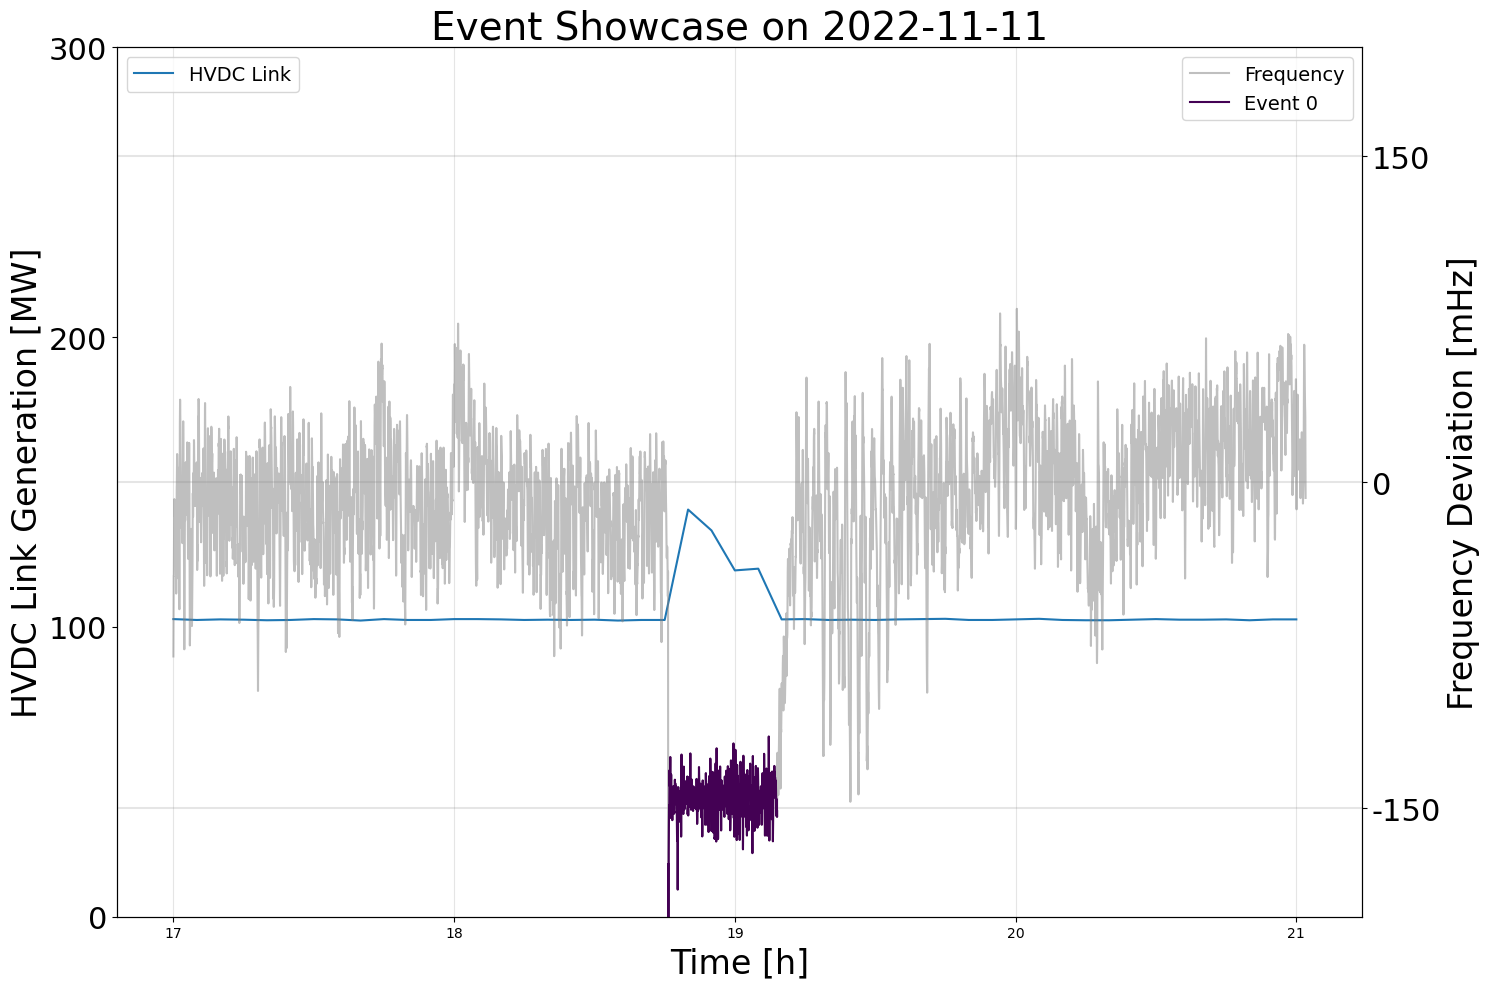

In [80]:
single_event_plotter(negative_events, frequency_data, generation_data, date='2022-11-11')

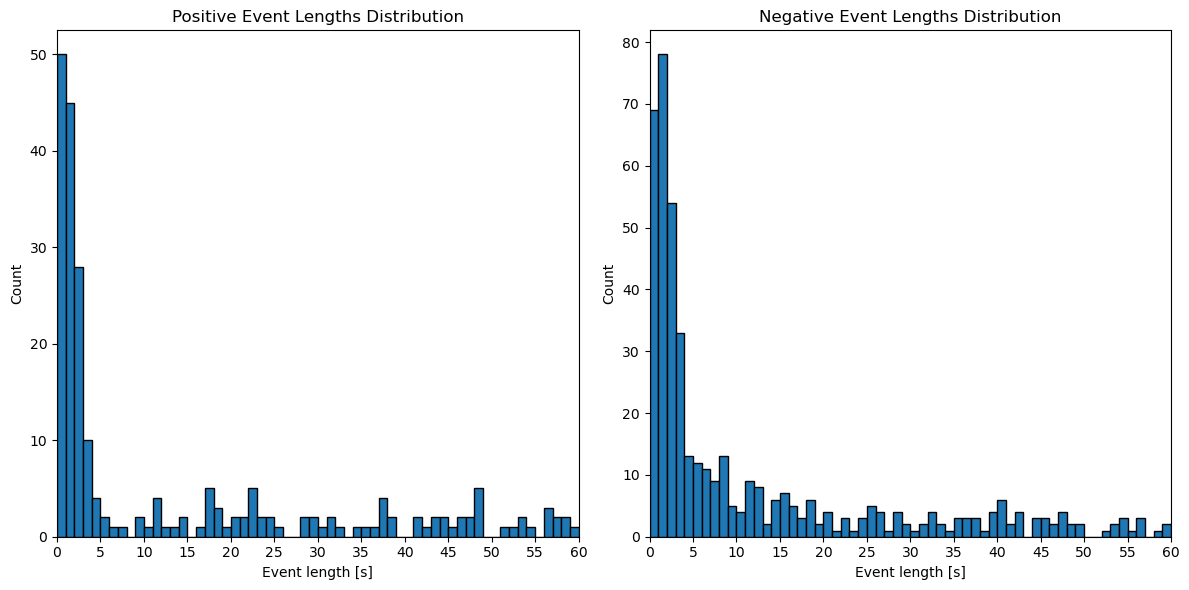

In [167]:
import matplotlib.pyplot as plt

# Calculation of Event Lengths
positive_events['Event Length'] = (positive_events['End'] - positive_events['Start']).dt.total_seconds() / 60
negative_events['Event Length'] = (negative_events['End'] - negative_events['Start']).dt.total_seconds() / 60

# Set up the matplotlib figure and axes for two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Positive Events Histogram
axs[0].hist(data=positive_events, x='Event Length', bins=60, edgecolor='k', range=(0, 1))
axs[0].set_title('Positive Event Lengths Distribution')
axs[0].set_xlim(0, 1)
axs[0].set_xlabel('Event length [s]')
axs[0].set_ylabel('Count')
# Set x-ticks for the positive events plot
tick_values = [i/12 for i in range(13)]  # Generates a list from 0 to 1 in steps of 1/12
tick_labels = [f"{5*i}" for i in range(13)]  # Labels for each tick, just the numbers
axs[0].set_xticks(tick_values)
axs[0].set_xticklabels(tick_labels)

# Negative Events Histogram
axs[1].hist(data=negative_events, x='Event Length', bins=60, edgecolor='k', range=(0, 1))
axs[1].set_title('Negative Event Lengths Distribution')
axs[1].set_xlim(0, 1)
axs[1].set_xlabel('Event length [s]')
axs[1].set_ylabel('Count')
# Set x-ticks for the negative events plot
axs[1].set_xticks(tick_values)
axs[1].set_xticklabels(tick_labels)

plt.tight_layout()
plt.savefig(f'plots/event_length_seconds.pdf', format='pdf')
plt.show()


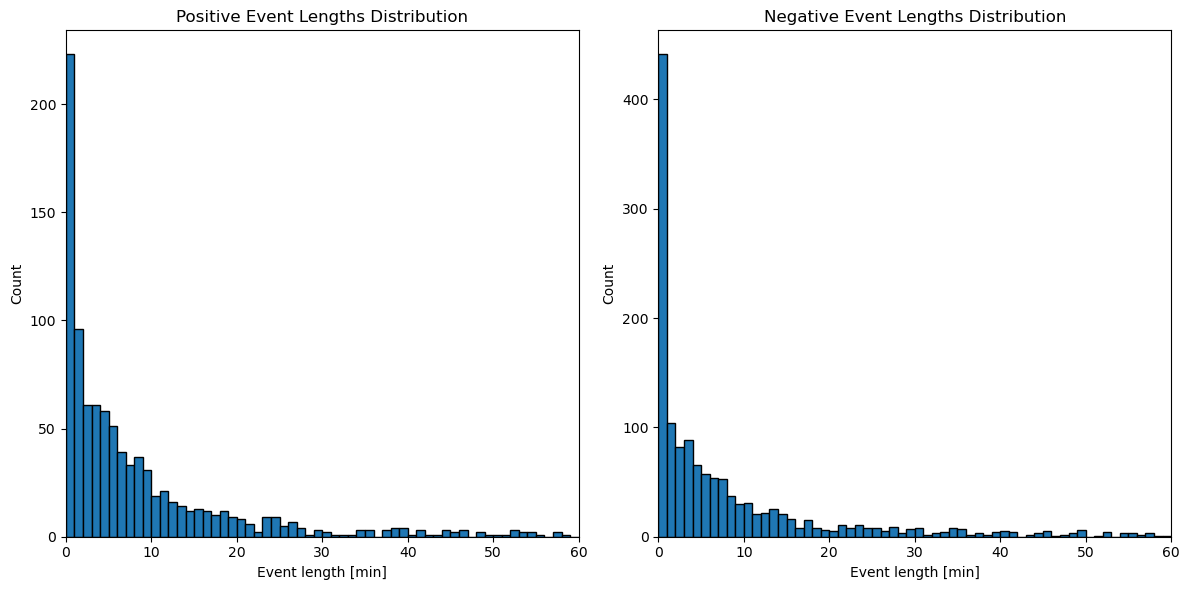

In [78]:
# Set up the matplotlib figure and axes for two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Positive Events Histogram
axs[0].hist(data=positive_events, x='Event Length', bins=60, edgecolor='k', range=(0, 60))
axs[0].set_title('Positive Event Lengths Distribution')
axs[0].set_xlabel('Event length [min]')
axs[0].set_ylabel('Count')
axs[0].set_xlim(0, 60)


# Negative Events Histogram
axs[1].hist(data=negative_events, x='Event Length', bins=60, edgecolor='k', range=(0, 60))
axs[1].set_title('Negative Event Lengths Distribution')
axs[1].set_xlabel('Event length [min]')
axs[1].set_ylabel('Count')
axs[1].set_xlim(0, 60)

plt.tight_layout()

plt.savefig(f'plots/event_length_minutes.pdf', format='pdf')

plt.show()

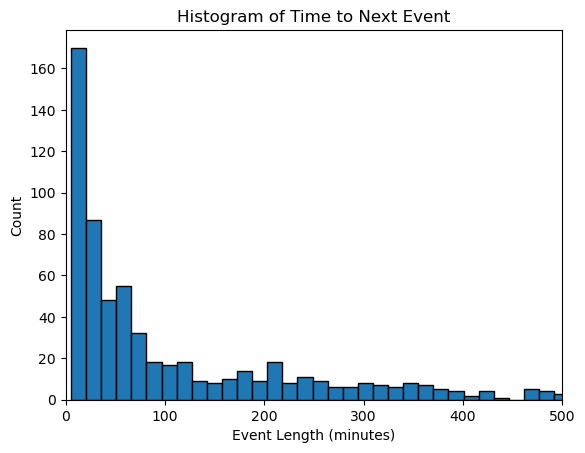

In [14]:
positive_events['Time to Next Event'] = (positive_events['Start'].shift(-1) - positive_events['End']).dt.total_seconds() / 60

plt.hist(data=positive_events, x='Time to Next Event', bins=10000, edgecolor='k')
plt.title('Histogram of Time to Next Event')
plt.xlim(0,500)
plt.xlabel('Event Length (minutes)')
plt.ylabel('Count')
plt.show()

In [11]:
generation_data['During_Event'] = 0

for _, event in positive_events.iterrows():
    start, end = event['Start'], event['End']
    generation_data.loc[start:end, 'During_Event'] = 1

for _, event in positive_events.iterrows():
    start, end = event['Start'], event['End']
    generation_data.loc[start:end, 'During_Event'] = -1

correlations = {}

for column in generation_data.columns:
    correlation = generation_data[column].corr(generation_data['During_Event'])
    correlations[column] = correlation

for column, correlation in correlations.items():
    print(f"{column}: {correlation}")

demand_programmed: 0.021236502058715797
demand_forecast: 0.022075248402309382
demand_real: 0.022744504325241794
generation_coal: -0.04225481491150682
generation_diesel_engines: 0.04828157619238721
generation_gas_turbine: 0.00651730448844338
generation_combined_cycle: 0.07531154134829497
balearic_peninsula_link: -0.02354934909256283
generation_solar: -0.10278681646953013
tnr: nan
trn: nan
generation_wind: -0.0024169541963301408
mallorca-menorca_link: nan
mallorca-ibiza_link: nan
generation_other_renewables: -0.05622561281427569
generation_waste: -0.009962693284089634
generation_auxiliary: 0.009030820371604112
generation_cogeneration: -0.011203485263090281
ibiza-formentera_link: nan
During_Event: 0.9999999999999998


/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/zakarieasharfeddine/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


# Event Prediction

In [177]:
import joblib

X_test = joblib.load('test_data.lib')
y_test = joblib.load('test_data_label.lib')

In [178]:
import xgboost as xgb

classifier = xgb.XGBClassifier()
classifier.load_model("model.json")

In [179]:
classifier.score(X_test, y_test)

0.9678245337929828

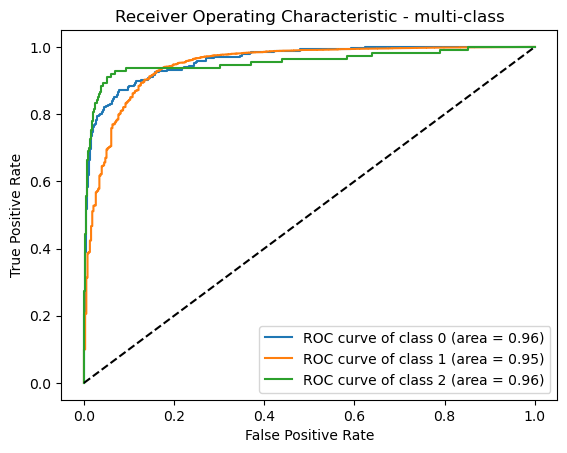

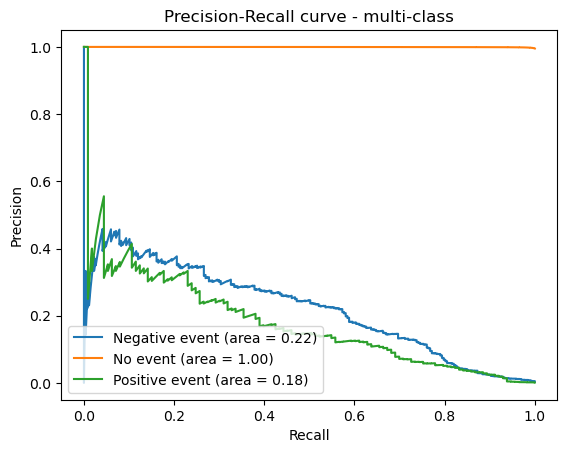

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, average_precision_score

probabilities = classifier.predict_proba(X_test)

# Number of classes
n_classes = probabilities.shape[1]

label = ['Negative event', 'No event', 'Positive event']

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, probabilities[:, i])
    roc_auc[i] = roc_auc_score(y_test == i, probabilities[:, i])

# Compute Precision-Recall curve and area for each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test == i, probabilities[:, i])
    average_precision[i] = average_precision_score(y_test == i, probabilities[:, i])

# Plot all ROC curves
plt.figure(1)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - multi-class')
plt.legend(loc="lower right")

# Plot all Precision-Recall curves
plt.figure(2)
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'{label[i]} (area = {average_precision[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve - multi-class')
plt.legend(loc="lower left")

plt.savefig(f'plots/pr_curve.pdf', format='pdf')

plt.show()


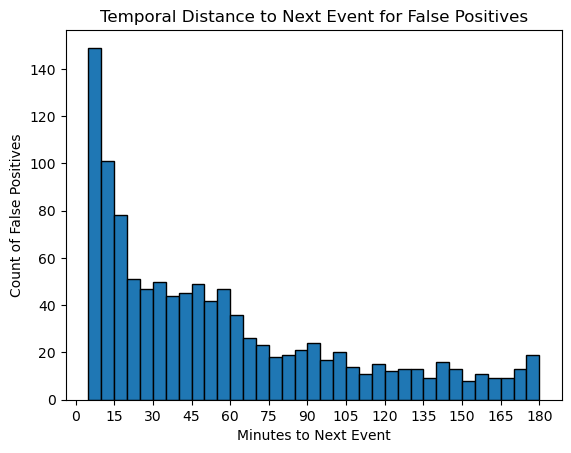

In [182]:
import numpy as np
import pandas as pd

y_pred = classifier.predict(X_test)

histogram_df = X_test.copy()
histogram_df["day"] = histogram_df["dayofmonth"]

histogram_df['datetime'] = pd.to_datetime(histogram_df[['year', 'month', 'day', 'hour', 'minute']])

histogram_df["event_pred"] = y_test


false_positives_indices = np.where((y_pred != y_test) & (y_pred != 1))[0]

event_datetimes = histogram_df[histogram_df['event_pred'] != 1]['datetime']

distances_to_next_event = []

for index in false_positives_indices:
    fp_datetime = histogram_df.iloc[index]['datetime']
    time_differences = (event_datetimes - fp_datetime).dt.total_seconds() / 60.0
    future_events_within_30 = time_differences[(time_differences > 0) & (time_differences <= 180)]
    if not future_events_within_30.empty:
        # Find the minimum time difference to the next event
        min_diff_to_next_event = future_events_within_30.min()
        distances_to_next_event.append(min_diff_to_next_event)
    else:
        distances_to_next_event.append(None)  # Or some placeholder to indicate no upcoming event within 30 mins




# Separate false positives for classes 0 and 2
false_positives_indices_0 = np.where((y_pred != y_test) & (y_pred == 0))[0]
false_positives_indices_2 = np.where((y_pred != y_test) & (y_pred == 2))[0]

# Combine false positive indices for more general processing
combined_false_positives_indices = {
    'class_0': false_positives_indices_0,
    'class_2': false_positives_indices_2
}

# Prepare the event_datetimes for non-event (non-class 1) predictions
event_datetimes = histogram_df[histogram_df['event_pred'] != 1]['datetime']

# Initialize an empty list to store distances
distances_to_next_event = []

# Process false positives for each class separately
for class_label, indices in combined_false_positives_indices.items():
    for index in indices:
        fp_datetime = histogram_df.iloc[index]['datetime']
        time_differences = (event_datetimes - fp_datetime).dt.total_seconds() / 60.0
        # Filter to find future events within 30 minutes to 3 hours (180 minutes)
        future_events_within_30 = time_differences[(time_differences > 0) & (time_differences <= 180)]
        if not future_events_within_30.empty:
            # Find the minimum time difference to the next event
            min_diff_to_next_event = future_events_within_30.min()
            distances_to_next_event.append(min_diff_to_next_event)

# Now, distances_to_next_event contains the distances to the next event for false positives of classes 0 and 2 combined
            
# Calculate the number of bins for a 5-minute interval across the range of distances
min_distance = min(distances_to_next_event)
max_distance = max(distances_to_next_event)
range_of_distances = max_distance - min_distance
num_bins = int(np.ceil(range_of_distances / 5))  # 5 minutes per bin

plt.hist(distances_to_next_event, bins=num_bins, edgecolor='k')
plt.xlabel('Minutes to Next Event')
plt.ylabel('Count of False Positives')
plt.title('Temporal Distance to Next Event for False Positives')

# Set x-ticks to every 15 minutes within the range of your data
xticks_range = np.arange(0, max_distance + 15, 15)  # Adjust the step to 15 minutes
plt.xticks(xticks_range)
plt.savefig(f'plots/temporal_distance_false_positve.pdf', format='pdf') 
plt.show()


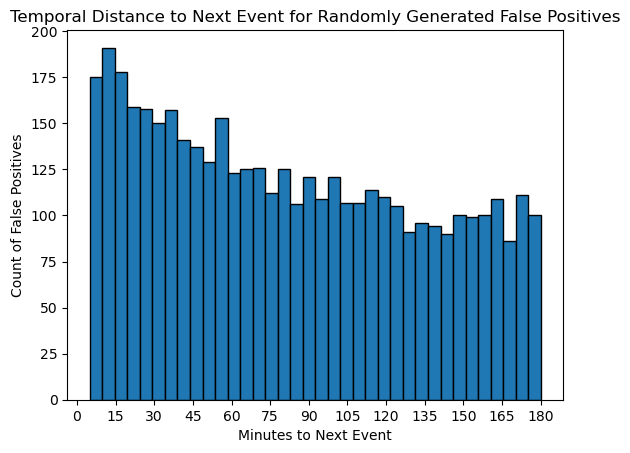

In [183]:
y_pred = classifier.predict(X_test)

histogram_df = X_test.copy()
histogram_df["day"] = histogram_df["dayofmonth"]

histogram_df['datetime'] = pd.to_datetime(histogram_df[['year', 'month', 'day', 'hour', 'minute']])

histogram_df["event_pred"] = y_test


actual_false_positives_indices = np.where((y_pred != y_test) & (y_pred != 1))[0]
num_false_positives = len(actual_false_positives_indices)

num_instances = len(y_test)  # Total number of instances in the dataset
# random_false_positives_indices = np.random.choice(num_instances, num_false_positives, replace=False)
random_false_positives_indices = np.random.choice(num_instances, 40000, replace=False)


event_datetimes = histogram_df[histogram_df['event_pred'] != 1]['datetime']

distances_to_next_event = []

for index in random_false_positives_indices:
    fp_datetime = histogram_df.iloc[index]['datetime']
    time_differences = (event_datetimes - fp_datetime).dt.total_seconds() / 60.0
    future_events_within_30 = time_differences[(time_differences > 0) & (time_differences <= 180)]
    if not future_events_within_30.empty:
        # Find the minimum time difference to the next event
        min_diff_to_next_event = future_events_within_30.min()
        distances_to_next_event.append(min_diff_to_next_event)
    else:
        distances_to_next_event.append(None)  # Or some placeholder to indicate no upcoming event within 30 mins

distances_to_next_event = [d for d in distances_to_next_event if d is not None]

# Calculate the number of bins for a 5-minute interval across the range of distances
min_distance = min(distances_to_next_event)
max_distance = max(distances_to_next_event)
range_of_distances = max_distance - min_distance
num_bins = int(np.ceil( 180 / 5))  # 5 minutes per bin

plt.hist(distances_to_next_event, bins=num_bins, edgecolor='k')
plt.xlabel('Minutes to Next Event')
plt.ylabel('Count of False Positives')
plt.title('Temporal Distance to Next Event for Randomly Generated False Positives')

# Set x-ticks to every 15 minutes within the range of your data
xticks_range = np.arange(0, max_distance + 15, 15)  # Adjust the step to 15 minutes
plt.xticks(xticks_range)

plt.savefig(f'plots/temporal_distance_random_false_positve.pdf', format='pdf')


plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

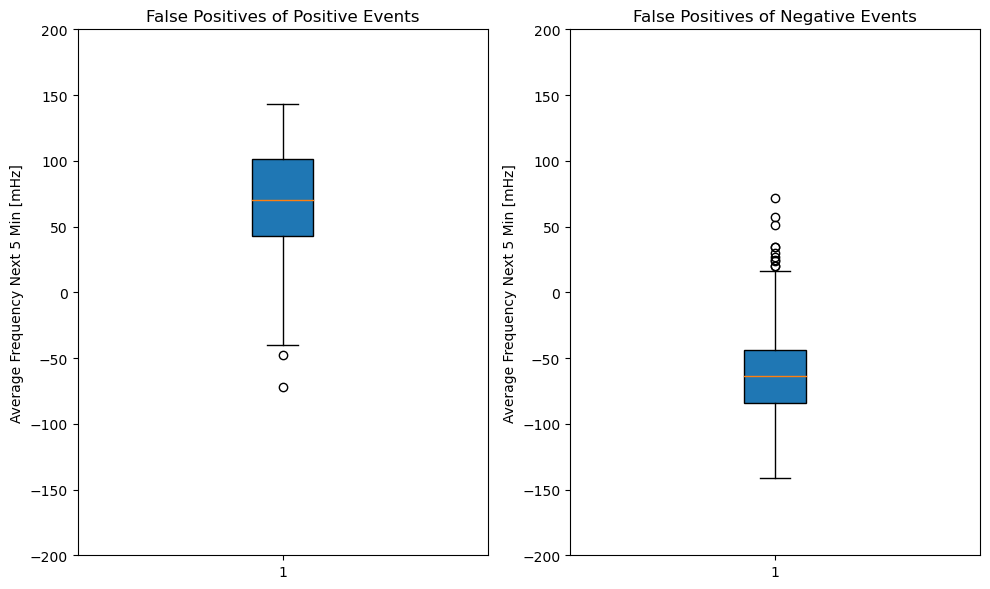

In [185]:
false_positives_indices_negative_events = np.where((y_pred != y_test) & (y_pred == 0))[0]

false_positives_indices_positve_events = np.where((y_pred != y_test) & (y_pred == 2))[0]

frequency_data = frequency_data.to_frame()
frequency_data.rename(columns={0: 'frequency'}, inplace=True)

# Step 1: Filter the histogram_df for false positive instances for positive and negative events
false_positive_df = histogram_df.iloc[false_positives_indices]
positive_events_fp = histogram_df.iloc[false_positives_indices_positve_events]  # Positive events classified incorrectly
negative_events_fp = histogram_df.iloc[false_positives_indices_negative_events]  # Negative events classified incorrectly

# Convert the 'datetime' column to be timezone-aware, matching 'frequency_data'
positive_events_fp['datetime'] = positive_events_fp['datetime'].dt.tz_localize('Europe/Madrid')
negative_events_fp['datetime'] = negative_events_fp['datetime'].dt.tz_localize('Europe/Madrid')


# Function to calculate the average frequency over the next 5 minutes for a given datetime
def calculate_average_frequency(dt, frequency_df):
    end_time = dt + pd.Timedelta(minutes=5)
    freq_range = frequency_df.loc[dt:end_time]
    return freq_range['frequency'].mean()

# Step 2: Calculate average frequencies for the next 5 minutes for each false positive event
positive_events_fp['avg_frequency_next_5min'] = positive_events_fp['datetime'].apply(lambda x: calculate_average_frequency(x, frequency_data))
negative_events_fp['avg_frequency_next_5min'] = negative_events_fp['datetime'].apply(lambda x: calculate_average_frequency(x, frequency_data))

# Step 3: Plot the box plots for positive and negative false positive events
plt.figure(figsize=(10, 6))

# Box plot for positive events
plt.subplot(1, 2, 1)
plt.boxplot(positive_events_fp['avg_frequency_next_5min'].dropna(), patch_artist=True)
plt.title('False Positives of Positive Events')
plt.ylabel('Average Frequency Next 5 Min [mHz]')
plt.ylim(-200,200)

# Box plot for negative events
plt.subplot(1, 2, 2)
plt.boxplot(negative_events_fp['avg_frequency_next_5min'].dropna(), patch_artist=True)
plt.title('False Positives of Negative Events')
plt.ylabel('Average Frequency Next 5 Min [mHz]')
plt.ylim(-200,200)

plt.tight_layout()

plt.savefig(f'plots/boxplot_false_positives.pdf', format='pdf') 

plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

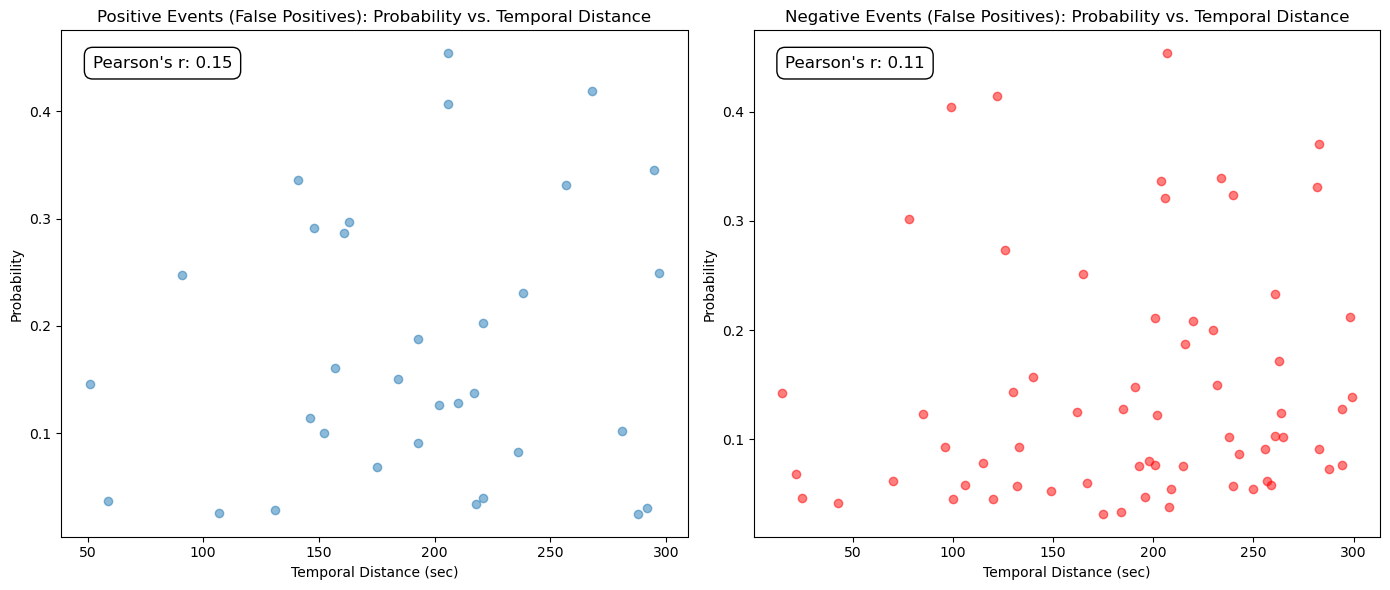

In [196]:
import scipy.stats

true_positives_indices_negative_events = np.where((0 == y_test) & (y_pred == 1))[0]

true_positives_indices_positve_events = np.where((2 == y_test) & (y_pred == 1))[0]

positive_events_fp = histogram_df.iloc[true_positives_indices_positve_events]  # Positive events classified correctly
negative_events_fp = histogram_df.iloc[true_positives_indices_negative_events]  # Negative events classified correctly

# Convert the 'datetime' column to be timezone-aware, matching 'frequency_data'
positive_events_fp['datetime'] = positive_events_fp['datetime'].dt.tz_localize('Europe/Madrid')
negative_events_fp['datetime'] = negative_events_fp['datetime'].dt.tz_localize('Europe/Madrid')


def find_first_datetime_above_threshold_positive(dt,frequency_df):
    end_time = dt + pd.Timedelta(minutes=5)
    freq_range = frequency_df.loc[dt:end_time]
    # Identifying points where frequency exceeds the threshold
    exceeds_threshold = freq_range['frequency'] >= 150

    # Finding the first occurrence where frequency exceeds the threshold
    return exceeds_threshold.idxmax()

def find_first_datetime_above_threshold_negative(dt,frequency_df):
    end_time = dt + pd.Timedelta(minutes=5)
    freq_range = frequency_df.loc[dt:end_time]
    # Identifying points where frequency exceeds the threshold
    exceeds_threshold = freq_range['frequency'] <= -150

    
    # Finding the first occurrence where frequency exceeds the threshold
    return exceeds_threshold.idxmax()



# Step 2: Calculate average frequencies for the next 5 minutes for each false positive event
positive_events_fp['Start'] = positive_events_fp['datetime'].apply(lambda x: find_first_datetime_above_threshold_positive(x, frequency_data))
negative_events_fp['Start'] = negative_events_fp['datetime'].apply(lambda x: find_first_datetime_above_threshold_negative(x, frequency_data))


positive_events_fp['Temporal_Distance_Sec'] = (positive_events_fp['Start'] - positive_events_fp['datetime']).dt.total_seconds().abs()
negative_events_fp['Temporal_Distance_Sec'] = (negative_events_fp['Start'] - negative_events_fp['datetime']).dt.total_seconds().abs()

X_test_copy = X_test.copy()
X_test_copy['class_0_probability'] = classifier.predict_proba(X_test)[:, 0]
X_test_copy['class_2_probability'] = classifier.predict_proba(X_test)[:, 2]


positive_events_fp['Probability'] = X_test_copy.iloc[true_positives_indices_positve_events]['class_2_probability'].values
negative_events_fp['Probability'] = X_test_copy.iloc[true_positives_indices_negative_events]['class_0_probability'].values



# For Positive Events
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(positive_events_fp['Temporal_Distance_Sec'], positive_events_fp['Probability'], alpha=0.5)
plt.title('Positive Events (False Positives): Probability vs. Temporal Distance')
plt.xlabel('Temporal Distance (sec)')
plt.ylabel('Probability')

# Calculate and display Pearson correlation coefficient for positive events
correlation_coef_positive, _ = scipy.stats.pearsonr(positive_events_fp['Temporal_Distance_Sec'], positive_events_fp['Probability'])
plt.annotate(f"Pearson's r: {correlation_coef_positive:.2f}", 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, 
             color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# For Negative Events
plt.subplot(1, 2, 2)
plt.scatter(negative_events_fp['Temporal_Distance_Sec'], negative_events_fp['Probability'], alpha=0.5, color='red')
plt.title('Negative Events (False Positives): Probability vs. Temporal Distance')
plt.xlabel('Temporal Distance (sec)')
plt.ylabel('Probability')

# Calculate and display Pearson correlation coefficient for negative events
correlation_coef_negative, _ = scipy.stats.pearsonr(negative_events_fp['Temporal_Distance_Sec'], negative_events_fp['Probability'])
plt.annotate(f"Pearson's r: {correlation_coef_negative:.2f}", 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, 
             color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

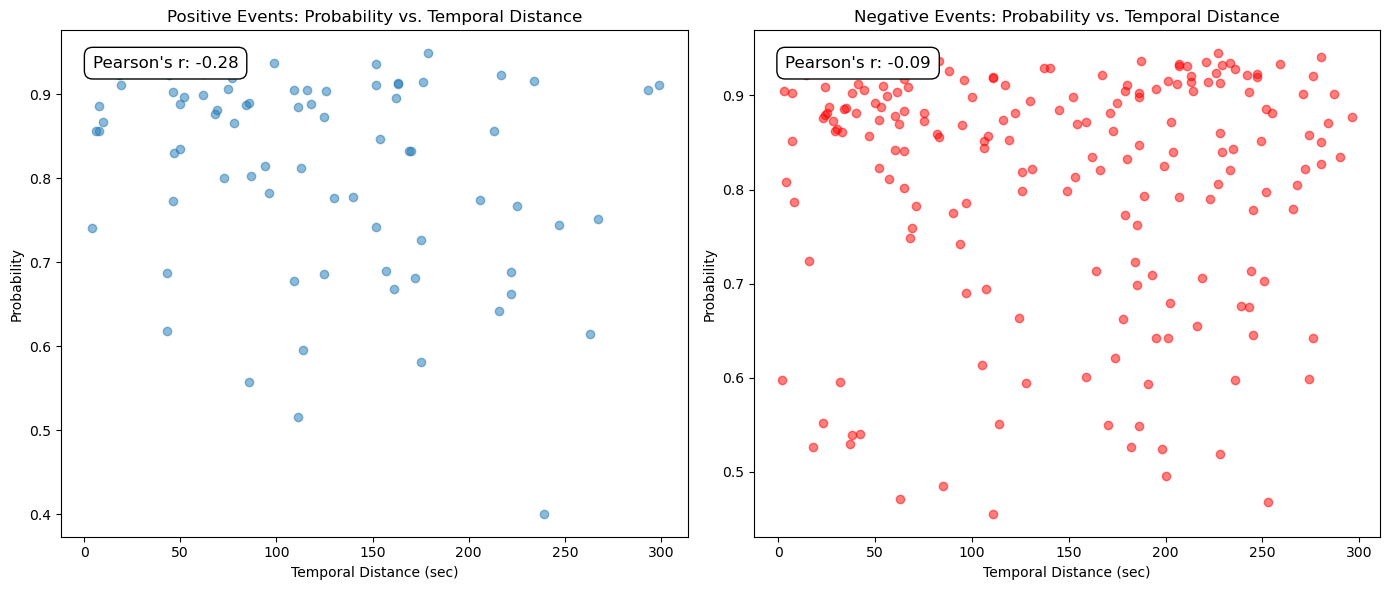

In [195]:

true_positives_indices_negative_events = np.where((y_pred == y_test) & (y_pred == 0))[0]

true_positives_indices_positve_events = np.where((y_pred == y_test) & (y_pred == 2))[0]

positive_events_fp = histogram_df.iloc[true_positives_indices_positve_events]  # Positive events classified correctly
negative_events_fp = histogram_df.iloc[true_positives_indices_negative_events]  # Negative events classified correctly

# Convert the 'datetime' column to be timezone-aware, matching 'frequency_data'
positive_events_fp['datetime'] = positive_events_fp['datetime'].dt.tz_localize('Europe/Madrid')
negative_events_fp['datetime'] = negative_events_fp['datetime'].dt.tz_localize('Europe/Madrid')



# Step 2: Calculate average frequencies for the next 5 minutes for each true positive event
positive_events_fp['Start'] = positive_events_fp['datetime'].apply(lambda x: find_first_datetime_above_threshold_positive(x, frequency_data))
negative_events_fp['Start'] = negative_events_fp['datetime'].apply(lambda x: find_first_datetime_above_threshold_negative(x, frequency_data))


positive_events_fp['Temporal_Distance_Sec'] = (positive_events_fp['Start'] - positive_events_fp['datetime']).dt.total_seconds().abs()
negative_events_fp['Temporal_Distance_Sec'] = (negative_events_fp['Start'] - negative_events_fp['datetime']).dt.total_seconds().abs()

X_test_copy = X_test.copy()
X_test_copy['class_0_probability'] = classifier.predict_proba(X_test)[:, 0]
X_test_copy['class_2_probability'] = classifier.predict_proba(X_test)[:, 2]


positive_events_fp['Probability'] = X_test_copy.iloc[true_positives_indices_positve_events]['class_2_probability'].values
negative_events_fp['Probability'] = X_test_copy.iloc[true_positives_indices_negative_events]['class_0_probability'].values


# For Positive Events
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(positive_events_fp['Temporal_Distance_Sec'], positive_events_fp['Probability'], alpha=0.5)
plt.title('Positive Events: Probability vs. Temporal Distance')
plt.xlabel('Temporal Distance (sec)')
plt.ylabel('Probability')

# Calculate and display Pearson correlation coefficient for positive events
correlation_coef_positive, _ = scipy.stats.pearsonr(positive_events_fp['Temporal_Distance_Sec'], positive_events_fp['Probability'])
plt.annotate(f"Pearson's r: {correlation_coef_positive:.2f}", 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, 
             color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

# For Negative Events
plt.subplot(1, 2, 2)
plt.scatter(negative_events_fp['Temporal_Distance_Sec'], negative_events_fp['Probability'], alpha=0.5, color='red')
plt.title('Negative Events: Probability vs. Temporal Distance')
plt.xlabel('Temporal Distance (sec)')
plt.ylabel('Probability')

# Calculate and display Pearson correlation coefficient for negative events
correlation_coef_negative, _ = scipy.stats.pearsonr(negative_events_fp['Temporal_Distance_Sec'], negative_events_fp['Probability'])
plt.annotate(f"Pearson's r: {correlation_coef_negative:.2f}", 
             xy=(0.05, 0.95), xycoords='axes fraction', 
             ha='left', va='top', fontsize=12, 
             color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


In [ ]:
def format_column_name(col):
    # Criteria for adding " Frequency" at the end
    criteria = ['emv_', 'ema_', 'squared_deviations']
    # Split by underscore and capitalize each word
    words = [word.capitalize() for word in col.split('_')]
    # Join back with space
    formatted_name = ' '.join(words)
    # Check if any criteria is in the original column name and add " Frequency" if true
    if any(crit in col for crit in criteria):
        formatted_name += ' Frequency'
    return formatted_name

# change the names of the futures for readability purposes


In [ ]:
# Create a mapping from old column names to new column names
new_columns = {col: format_column_name(col) for col in X_test.columns}

# Rename the columns in X_test
X_test.rename(columns=new_columns, inplace=True)

In [ ]:
import shap

#load the shap_values created by running forecasting_final.ipynb
shap_values = joblib.load('shap_values.lib')

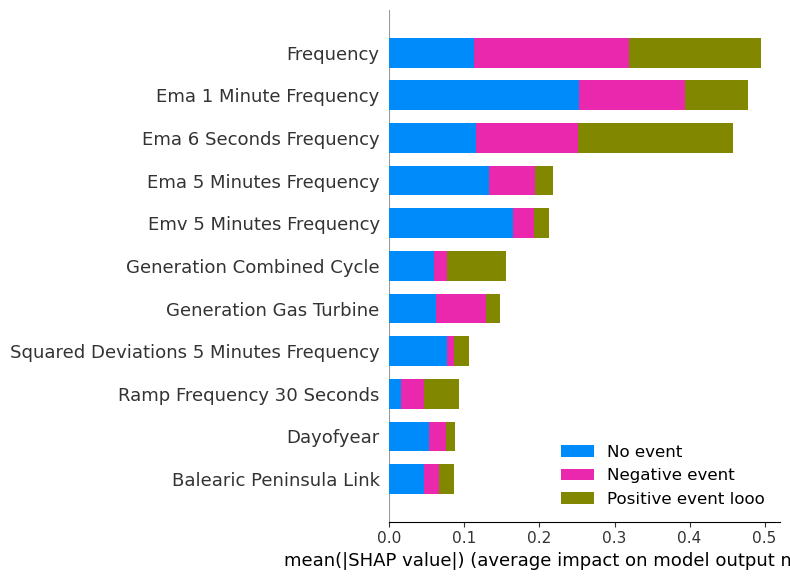

In [ ]:
# 11 most important features

shap.summary_plot(shap_values, X_test, show=False, max_display=11, class_names=['Negative event', 'No event','Positive event looo'])
plt.savefig(f'plots/combined_feature_importance.pdf', format='pdf') 
plt.show()

Class 0 SHAP Summary


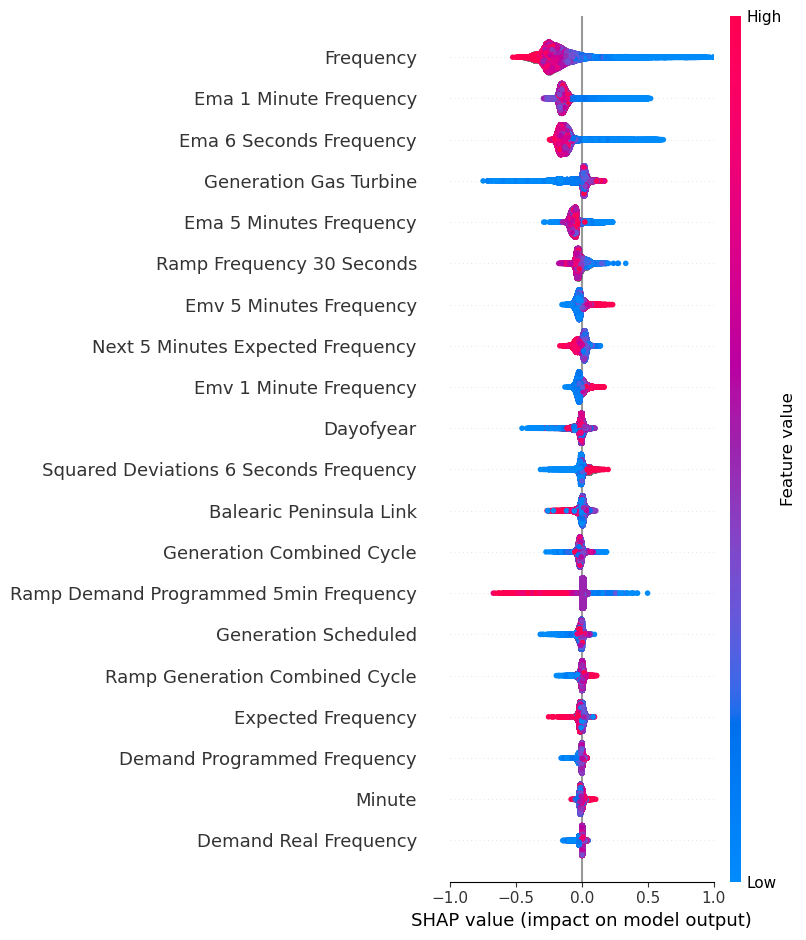

Class 1 SHAP Summary


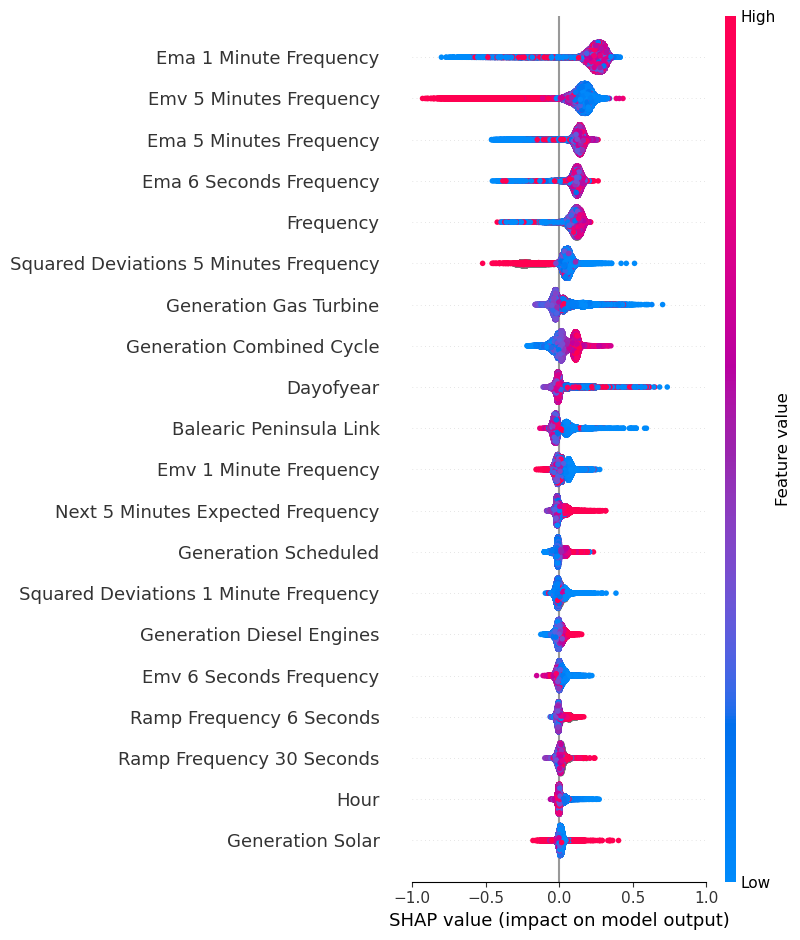

Class 2 SHAP Summary


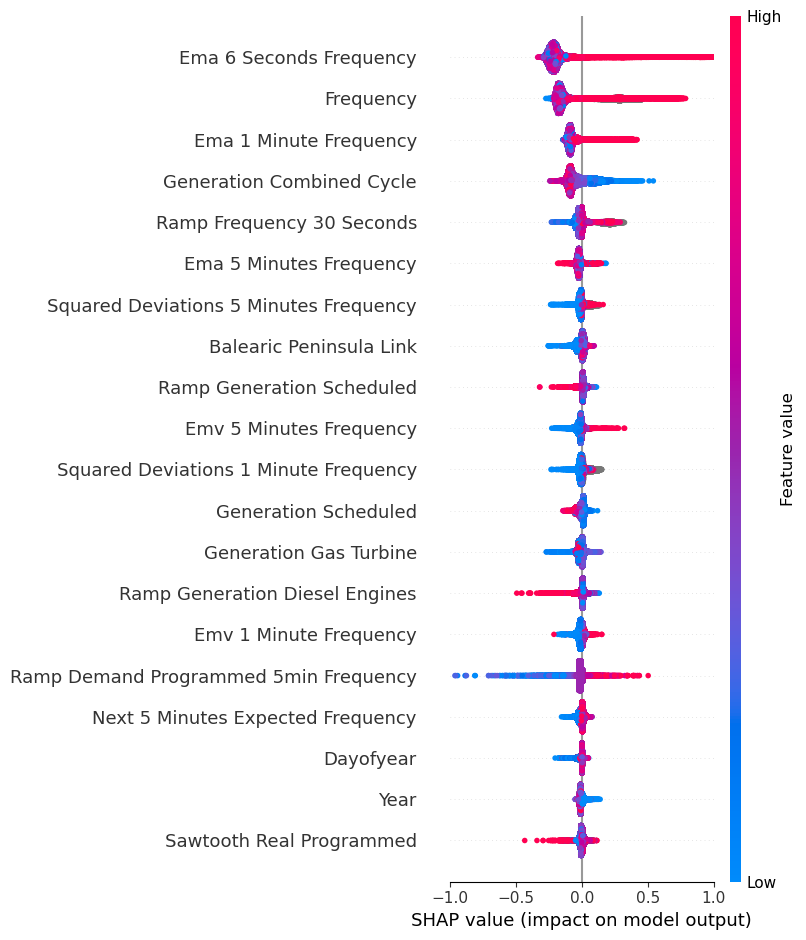

In [ ]:
#0 = negative events
#1 = no event
#2 = postive events


# Assuming shap_values is your list of SHAP values for each class
for i in range(3):
    print(f"Class {i} SHAP Summary")
    shap.summary_plot(shap_values[i], X_test, show=False)
    ax = plt.gca()
    # change the min and max value of xaxis by changing the arguments of:
    ax.set_xlim(-1, 1)
    plt.savefig(f'plots/class{i}_shap_summary.pdf', format='pdf') 
    plt.show()

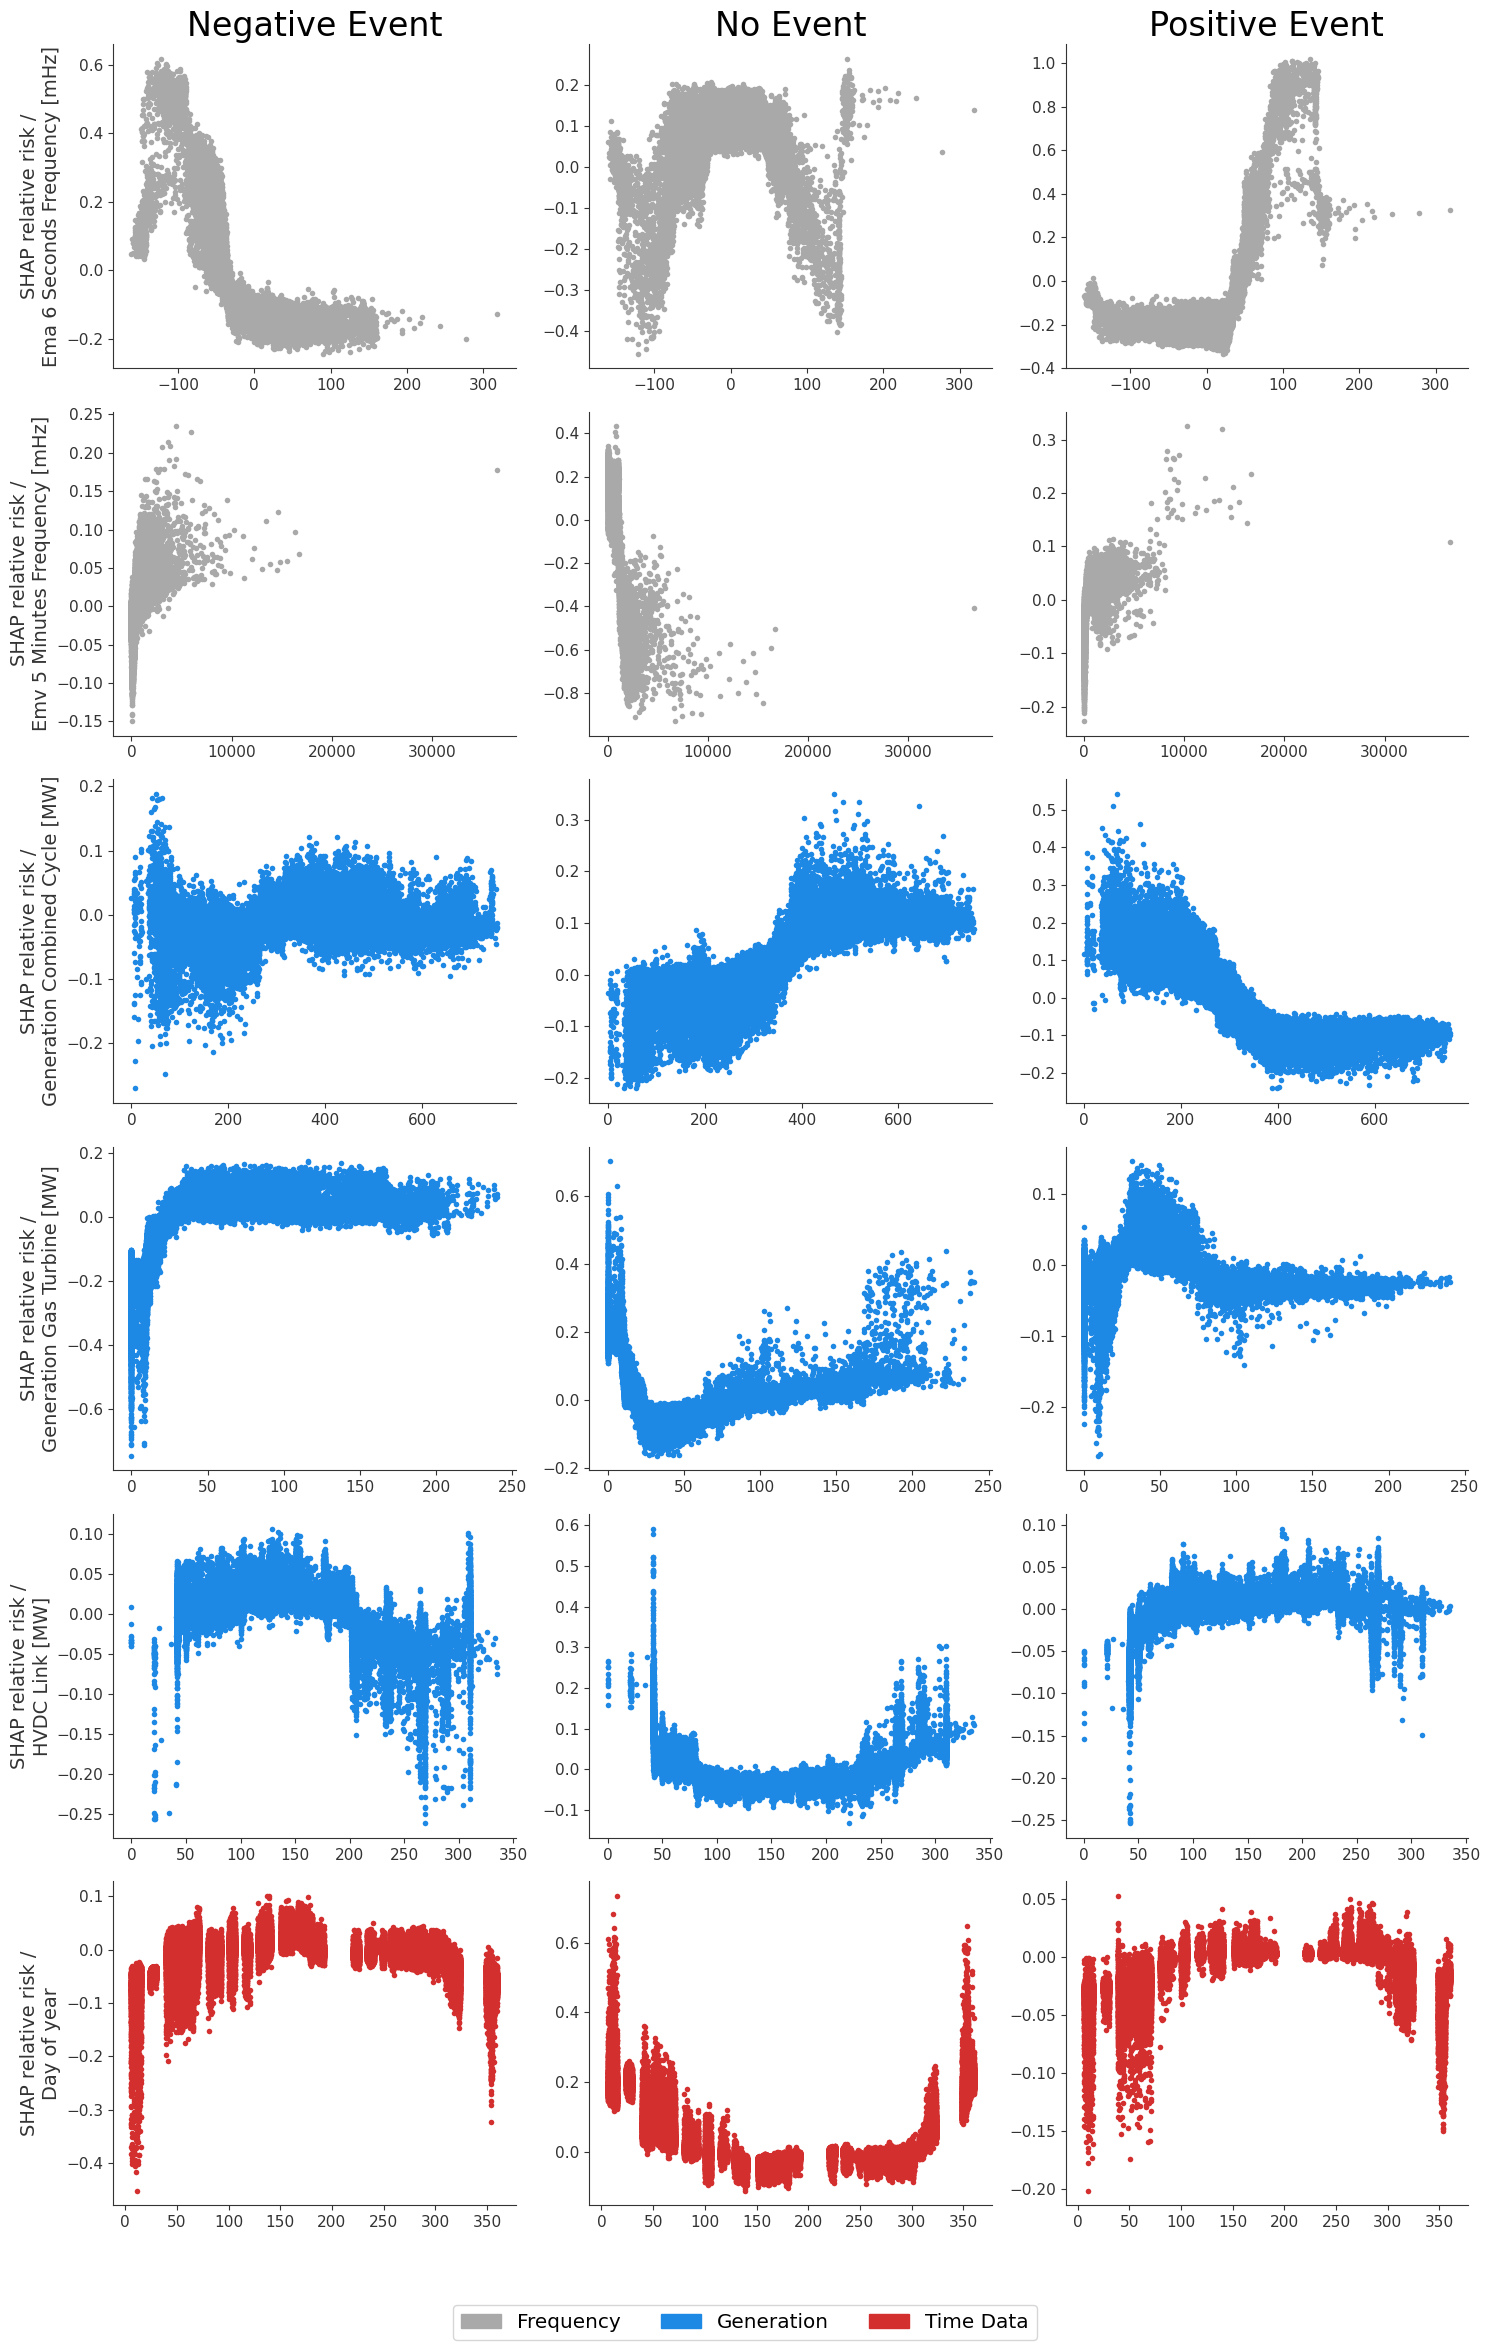

In [ ]:
import matplotlib.patches as mpatches

# Define the features and classes
features = [
    'Ema 6 Seconds Frequency',
    'Emv 5 Minutes Frequency',
    'Generation Combined Cycle',
    'Generation Gas Turbine',
    'Balearic Peninsula Link',
    'Dayofyear'
]

features_label = [
    'SHAP relative risk /\nEma 6 Seconds Frequency [mHz]',
    'SHAP relative risk /\nEmv 5 Minutes Frequency [mHz]',
    'SHAP relative risk /\nGeneration Combined Cycle [MW]',
    'SHAP relative risk /\nGeneration Gas Turbine [MW]',
    'SHAP relative risk /\nHVDC Link [MW]',
    'SHAP relative risk /\nDay of year'
]
classes = [0, 1, 2]

class_names = ['Negative Event', 'No Event', 'Positive Event']



colors = ['#A9A9A9'] * 2 + ['#1E88E5'] * 3 + ['#D32F2F']

fig, axs = plt.subplots(len(features), len(classes), figsize=(15, 25))

for class_idx, class_val in enumerate(classes):
    for feature_idx, feature in enumerate(features):
        ax = axs[feature_idx, class_idx]
        color = colors[feature_idx]  # Select the color based on the row
        shap.dependence_plot(feature, shap_values[class_val], X_test, ax=ax, show=False, color=color, interaction_index=None)
        
        if class_idx == 0:
            ax.set_ylabel(features_label[feature_idx], size=14)
        else:
            ax.set_ylabel('')
        
        ax.set_xlabel('')
        if feature_idx == 0:
            ax.set_title(f'{class_names[class_idx]}', size=24)


# Adjust the layout to make space for the legend below the plots
legend_patches = [
    mpatches.Patch(color='#A9A9A9', label='Frequency'),
    mpatches.Patch(color='#1E88E5', label='Generation'),
    mpatches.Patch(color='#D32F2F', label='Time Data')
]

# Apply tight layout with padding to make room for the legend below the plots
plt.tight_layout(rect=[0, 0.1, 1, 1])

# Adjust the legend to be closer to the plots
plt.figlegend(handles=legend_patches, loc='upper center', ncol=3, fontsize='x-large', bbox_to_anchor=(0.5, 0.08))
plt.savefig(f'plots/feature_dependence.pdf', format='pdf')
plt.show()
